# Analise da Influência da Quarentena nos Casos de COVID-19
Sendo o COVID-19 o tema mais importante no mundo atual e o Brasil estando em segundo no ranking dos paises com mais casos confirmados do virus, uma análise do que esta acontecendo no território Brasileiro pode ser um excelente insight para melhorarmos nossa forma de evitar que o virus se espalhe.</br></br>
**Hipotese:** As porcentagens de quarentena registradas tem uma relação direta com o notável aumento de casos de COVID-19 no Brasil? Se sim, um isolamento mais rígido teria resultado em um menor numero de casos?

In [1]:
# Modules
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import datetime as dt
import json
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## **Data Sets**
Os sets de dados utilizados nessa análise são os seguintes:</br>  
* Brasil.io - [COVID-19](https://brasil.io/dataset/covid19/caso_full/ "COVID-19")  
* Governo de São Paulo - [Adesão ao Isolamento](https://www.saopaulo.sp.gov.br/coronavirus/isolamento/ "Adesão ao Isolamento")
  
As informações referentes a esses Data Sets se encontram nos link providenciados. As análises feitas partem do principio que os dados coletados são *verídicos*.

In [2]:
# Data sets
df_covid = pd.read_csv("./covid19-Brasil_io.csv", parse_dates = ['date'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254862 entries, 0 to 254861
Data columns (total 11 columns):
date                              254862 non-null datetime64[ns]
state                             254862 non-null object
city                              252099 non-null object
place_type                        254862 non-null object
confirmed                         254862 non-null int64
deaths                            254862 non-null int64
is_last                           254862 non-null bool
estimated_population_2019         253403 non-null float64
city_ibge_code                    253403 non-null float64
confirmed_per_100k_inhabitants    247423 non-null float64
death_rate                        254862 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 19.7+ MB


In [3]:
# DataFrame import and date wrangling
df_taxas = pd.read_csv("./Taxa_Isolamento_Município_Dados.csv")
df_taxas['Data'] = df_taxas['Data'].str[-5:]
df_taxas['Data'] = df_taxas['Data'].apply(lambda x: "{0}{1}".format(x, "/2020"))
df_taxas['Data'] = pd.to_datetime(df_taxas['Data'], dayfirst = True)
df_taxas.rename({'Índice De Isolamento':'Porcentagem'}, axis=1, inplace = True)
df_taxas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10920 entries, 0 to 10919
Data columns (total 9 columns):
Data                 10920 non-null datetime64[ns]
DATA_DIA             10920 non-null object
DIA                  10920 non-null object
Município1           10920 non-null object
STR_DATA             10920 non-null object
UF1                  10920 non-null object
Escala de cor        10920 non-null object
Number of Records    10920 non-null int64
Porcentagem          10920 non-null object
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 767.9+ KB


## **Data Analysis**
Parte da análise de dados é a limpeza dos mesmos, conechido como *Data Wrangling*. É realizado esse processo para trabalhar com dados consistentes, sendo assim, formatamos as datas para que todas sigam um padrão e excluimos os dados *NaN* ou *NULL*, que posteriormente podem afetar as análises realizadas.

In [4]:
df_covid.dropna(inplace = True)
df_covid.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-06-25,AC,Acrelândia,city,185,3,True,15256.0,1200013.0,1212.63765,0.0162
1,2020-06-25,AC,Assis Brasil,city,147,5,True,7417.0,1200054.0,1981.93340,0.0340
2,2020-06-25,AC,Brasiléia,city,287,6,True,26278.0,1200104.0,1092.16835,0.0209
3,2020-06-25,AC,Bujari,city,151,3,True,10266.0,1200138.0,1470.87473,0.0199
4,2020-06-25,AC,Capixaba,city,128,5,True,11733.0,1200179.0,1090.94008,0.0391


In [5]:
df_taxas.dropna(inplace = True)
df_taxas.head()

,Data,DATA_DIA,DIA,Município1,STR_DATA,UF1,Escala de cor,Number of Records,Porcentagem
0,2020-06-24,Wednesday,Quarta-feira,AMERICANA,Ranking dos municípios (24/6/2020),SP,>40-50%,1,44%
1,2020-06-24,Wednesday,Quarta-feira,AMPARO,Ranking dos municípios (24/6/2020),SP,>40-50%,1,40%
2,2020-06-24,Wednesday,Quarta-feira,ARAÇATUBA,Ranking dos municípios (24/6/2020),SP,Até 40%,1,39%
3,2020-06-24,Wednesday,Quarta-feira,ARARAQUARA,Ranking dos municípios (24/6/2020),SP,Até 40%,1,38%
4,2020-06-24,Wednesday,Quarta-feira,ARARAS,Ranking dos municípios (24/6/2020),SP,>40-50%,1,41%


### **Plotagem de Casos por Estados**
Para analisarmos qual a distribuição dos casos no teritorrio Brasileiro utilizamos os dados mais atuais e agrupamos eles por estados, somando a quantidade total dos casos acumulados de todas as cidades em cada estado.

In [6]:
# Estado 1.3 m vs dados 2.4 m
df_covid_summarize = df_covid[['state','city','confirmed']].loc[df_covid['is_last'] == True]
df_covid_ps = df_covid_summarize[['state','confirmed']].groupby('state').sum()

In [7]:
geodf_br = gpd.read_file('./br_states.geojson')
geodf_br = geodf_br.join(df_covid_ps, on = 'sigla')

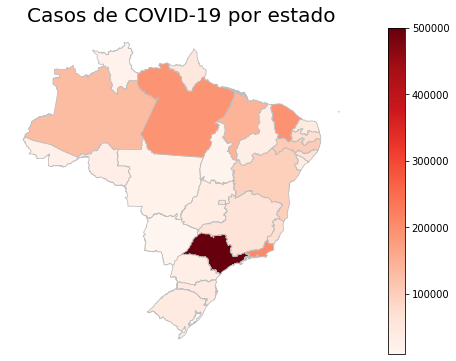

In [8]:
fig, ax = plt.subplots(figsize = (12,6))
ax.axis('off')
ax.set_title('Casos de COVID-19 por estado', fontsize = 20)
sm = plt.cm.ScalarMappable(cmap='Reds',
                           norm=plt.Normalize(vmin=10000, vmax = 500000))
cbar = fig.colorbar(sm)
geodf_br.plot(column = 'confirmed', cmap = 'Reds', 
              linewidth = 0.8, ax =ax, edgecolor = '0.75');

**Importante:** Até a última data reportada nos Data Sets (25/06), tem um total de casos confirmados acumulados de 2.4 milhões, enquanto o site de saúde do governo para essa mesma data reportava 1.3 milhões de casos. Essa diferença de casos pode acontecer por uma série de motivos, os quais não iremos discutir aqui. Caso haja alguma dúvida, podemos ir no site dos dados, na área do *FAQ* e entender como os dados foram coletados.  

### **Plotagem da distibuicao dos casos em São Paulo**
Como podemos observar na imagem anterior, o estado de São Paulo representa por volta de um quinto dos casos confirmados no país. Portanto, iremos analisar mais a fundo o que está acontecendo no Estado de São Paulo.

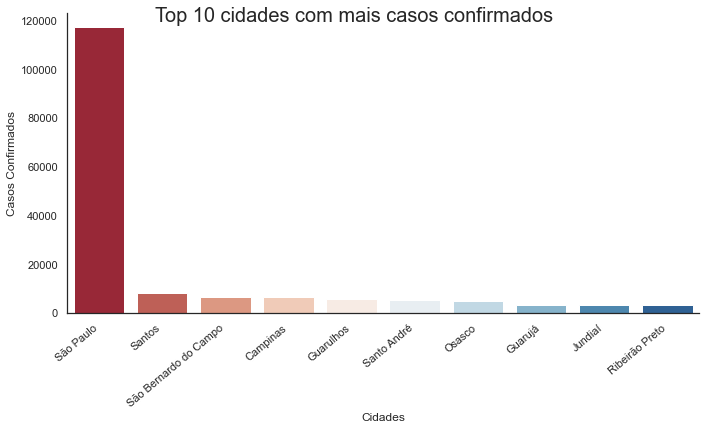

In [9]:
sns.set(style = "white")
df_sp = df_covid_summarize.loc[df_covid_summarize['state'] == 'SP']
df_sp = df_sp.sort_values(by = 'confirmed', ascending = False)[:10]
ax = sns.catplot(x = 'city', 
                 y = 'confirmed', 
                 kind = 'bar',
                 palette =sns.color_palette("RdBu", n_colors= len(df_sp.index)), 
                 data = df_sp,
                 height = 5, aspect = 2)
ax.fig.suptitle('Top 10 cidades com mais casos confirmados', fontsize = 20)
ax.set_axis_labels('Cidades','Casos Confirmados')
ax.set_xticklabels(rotation = 40, ha = 'right')
ax.set_yticklabels(va = 'center_baseline');

Só na cidade de São Paulo foram reportados quase 120 mil casos, isso representa por volta de um quarto dos casos do Estado, e assim representando 1/20 dos casos confirmados no territorio nacional.  

### **Análise de quarentena na cidade de São Paulo**
Usando os dados da cidade de São Paulo como o nosso escopo para respondermos a nossa hipótese, analisaremos como tem sido as porcentagens de isolamento registradas.

In [10]:
df_taxas_sp = df_taxas[['Data','DATA_DIA','UF1','Porcentagem']].loc[
                (df_taxas['Município1'].str.lower() == "são paulo") & 
                (df_taxas['Data'] >= '2020-03-16')]
df_taxas_sp.sort_values(by = 'Data', inplace = True)
df_taxas_sp['Porcentagem'] = df_taxas_sp['Porcentagem'].apply(lambda x: x.replace('%',''))

df_casos_sp = df_covid[['date', 'confirmed']].loc[(df_covid['city'].str.lower() == "são paulo") & 
                 (df_covid['date'].isin(pd.date_range('2020-03-17','2020-06-24')))]

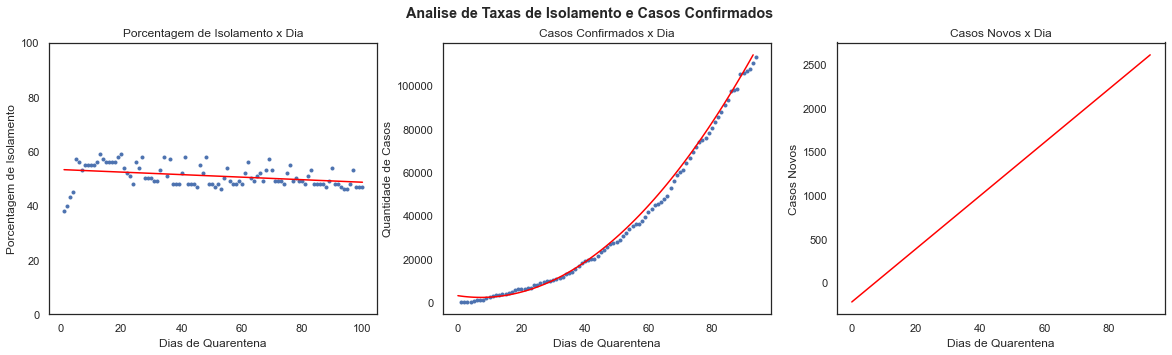

In [11]:
# Pesquisar como fazer um polyfit de dim 2
# Assumindo que o dia 1 eh 17/03/2020
X1 = np.array([int(x+1) for x in range(len(df_taxas_sp['Porcentagem']))])
Y1 = df_taxas_sp['Porcentagem'].apply(lambda x: int(x))
X2 = np.array([int(x+1) for x in range(len(df_casos_sp['confirmed']))])
Y2 = df_casos_sp['confirmed'][::-1]

m1, b1 = np.polyfit(X1,Y1,1)
a,c,d = np.polyfit(X2,Y2,2)

fig, axs = plt.subplots(1,3, figsize = (20,5))

axs[0].plot(X1,Y1,'.')
axs[0].plot(X1, m1*X1+b1, '-', color = 'red')
axs[0].set_ylim(0,100)
axs[0].set_xlabel('Dias de Quarentena')
axs[0].set_ylabel('Porcentagem de Isolamento')
axs[0].set_title('Porcentagem de Isolamento x Dia')

axs[1].plot(X2,Y2,'.')
axs[1].plot(a*(X2**2)+c*X2+d, '-', color = 'red')
axs[1].set_xlabel('Dias de Quarentena')
axs[1].set_ylabel('Quantidade de Casos')
axs[1].set_title('Casos Confirmados x Dia')

axs[2].plot(2*a*X2 + c, '-', color = 'red')
axs[2].set_xlabel('Dias de Quarentena')
axs[2].set_ylabel('Casos Novos')
axs[2].set_title('Casos Novos x Dia')
fig.suptitle('Analise de Taxas de Isolamento e Casos Confirmados', weight = 'bold');

Como podemos ver no primeiro quadro, o isolamento social esta distribuido em sua maioria entre a faixa de 50-60 por cento, a linha vermelha representa a função que mais se adequa a essa distribuição dos dados. 

No segundo quadro, podemos observar como tem aumentado os casos confirmados na cidade de São Paulo. Embora ja escutamos algumas vezes, o crescimento do virus acontece de forma exponencial, nesse caso achamos uma curva, especificamente uma função quadrática, que se adequa aos dados. Foi feito dessa maneira, para quantificar a taxa de crescimento dos casos por dias no terceiro quadro, isso foi realizado derivando a função quadrática.  

Assim podemos concluir, preocupantemente que, enquanto a tendência dos casos é aumentar, contrariamente a tendência do isolamento social é diminuir.

In [12]:
# Fazer Joindo DF pela data atual e add coluna de data de  dias atras
# Tratativa de Datas faltantes
first = df_casos_sp['date'][-1:].values
last = df_casos_sp['date'][:1].values

miss_dates = pd.date_range(start = first[0], end = last[0]).difference(df_casos_sp['date'])
miss_dates = [x.to_datetime64() for x in miss_dates]
df_missing = pd.DataFrame(miss_dates, columns=['date'])

df_casos_sp = df_casos_sp.append(df_missing)
df_casos_sp.sort_values(by = 'date', inplace = True)
df_casos_sp.reset_index(inplace = True, drop = True)

fills = ['353','400','472','545','1107','1170']
df_casos_sp['confirmed'].loc[df_casos_sp.confirmed.isnull()] = fills
df_casos_sp['confirmed'] = df_casos_sp['confirmed'].astype('int64')

C:\Users\Bernardo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
# Colocando as datas como index
df_casos_sp['dia_atual'] = (df_casos_sp['date'] - df_casos_sp['date'].iloc[0]).dt.days
df_casos_sp.set_index('date', inplace=True)

df_taxas_sp.reset_index(inplace = True, drop = True)
df_taxas_sp['dia_atual'] = (df_taxas_sp['Data'] - df_taxas_sp['Data'].iloc[0]).dt.days
df_taxas_sp.set_index('Data', inplace=True)

In [14]:
# Criando os features novos para o nosso modelo
df_casos_sp['taxa_atual'] = 0
df_casos_sp['dia-3'] = df_casos_sp['dia_atual'] - 3
df_casos_sp['taxa-3'] = 0
df_casos_sp['dia-4'] = df_casos_sp['dia_atual'] - 4
df_casos_sp['taxa-4'] = 0
df_casos_sp['dia-5'] = df_casos_sp['dia_atual'] - 5
df_casos_sp['taxa-5'] = 0

In [15]:
# Realizando o Join das informacoes
df_casos_sp.taxa_atual.update(df_taxas_sp.Porcentagem)
df_casos_sp['taxa-3'] = df_casos_sp.taxa_atual.shift(periods= 3)
df_casos_sp['taxa-4'] = df_casos_sp.taxa_atual.shift(periods= 4)
df_casos_sp['taxa-5'] = df_casos_sp.taxa_atual.shift(periods= 5)

# Data Cleaning dos Dados missing
df_casos_sp.dropna(inplace=True)
df_casos_sp[['taxa_atual','taxa-3','taxa-4','taxa-5']] = df_casos_sp[['taxa_atual','taxa-3','taxa-4','taxa-5']].astype('int64')

## **Modeling**
Para a criação de um modelo temos que decidir quais serão nossas *features* ou variáveis. Nesse caso, foi realizada uma pesquisa para determinar qual era o periodo de contágio do virus. Segundo [esse artigo](https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295 "esse artigo") o período infeccioso do COVID-19 ocorre desde 3 dias antes de mostrar sintomas e dura na média uns 10 dias. Sendo assim, o DataFrame que usaremos para o modelo constará das porcentagens de isolamento e das datas atuais, 3, 4 e 5 dias prévios correspondentemente. 

In [16]:
# Identificando a correlação entre as variáveis
def plot_corr(df, size):
    corr = df.corr()    
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr, cmap = 'viridis')  
    plt.xticks(range(len(corr.columns)), corr.columns) 
    plt.yticks(range(len(corr.columns)), corr.columns)

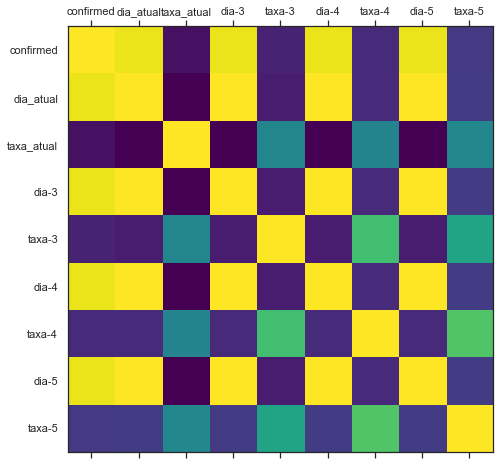

In [17]:
plot_corr(df_casos_sp, df_casos_sp.shape[1]/1.15)

A imagem mostrada acima corresponde a uma matriz de correlações. Geralmente uma matriz de correlações assume valores entre -1 e 1, assim demostrando se as variáveis escolhidas tem uma relação inversamente ou diretamente proporcional correspondentemente.  

Visualmente fica mais fácil de entender com um mapa de cores ao invés de uma matriz com a representação numérica. No caso da nossa matriz, os valores inversamente proporcionais são representados pelo roxo escuro e os valores diretamentes proporcionais pelo amarelo. Com isso podemos ver qual a correlação que a nossa variável *confirmed* tem com as colunas adicionadas com a finalidade de montar um modelo de previsão de casos.  

**Importante:** Correlação não implica causalidade.

In [18]:
# Definicao de Variaveis
atributos = ['dia_atual','taxa_atual','dia-3','taxa-3','dia-4','taxa-4','dia-5','taxa-5']
previsao = ['confirmed']

In [19]:
# Criacao de objetos
X = df_casos_sp[atributos].values
Y = df_casos_sp[previsao].values

### **Model Training**
Após a divisão dos nossos atributos e a variável preditora devemos dividir nosso set de dados em sub sets de teste e treinamento para ver o comportamento do modelo e evitarmos *overfitting*. Para isso usamos a função *TimeSeriesSplit* de *scikit learn*, assim criando 10 sub sets de treinamento e teste.

O score que será calculado é conhecido como "*R-squared*". Ele indica o quanto a regressão linear se ajusta aos dados, sendo 1 um ajuste perfeito.

In [20]:
tss = TimeSeriesSplit(n_splits=10, max_train_size=12)
i = 0
for train_index, test_index in tss.split(X,y=Y):
    #print("TRAIN {0} \n TEST {1}".format(train_index, test_index))
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    reg = LinearRegression().fit(X_train, Y_train)
    print("Iteration {0} Score -> {1}".format(i, reg.score(X_test,Y_test)))
    i += 1

Iteration 0 Score -> 0.6308867265865858
Iteration 1 Score -> 0.7328619403289752
Iteration 2 Score -> 0.4638906155896178
Iteration 3 Score -> -0.2570036007621699
Iteration 4 Score -> 0.6618297380146546
Iteration 5 Score -> 0.9277062495124271
Iteration 6 Score -> 0.5898107735477596
Iteration 7 Score -> 0.5962753560499899
Iteration 8 Score -> 0.9489979729928809
Iteration 9 Score -> 0.9148941098682164


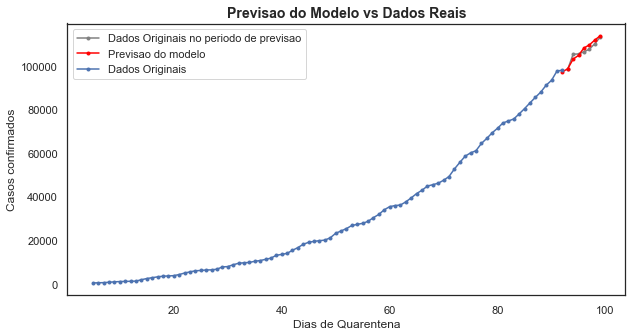

In [21]:
Y_prev = reg.predict(X_test)

fig, ax = plt.subplots(figsize = (10,5))
plt.plot(df_casos_sp.dia_atual.iloc[88:], df_casos_sp.confirmed.iloc[88:], marker = '.', color='gray')
plt.plot(X_test[:,:1], Y_prev, marker='.',color='red')
plt.plot(df_casos_sp.dia_atual.iloc[:88], df_casos_sp.confirmed.iloc[:88], marker = '.')
ax.set_ylabel('Casos confirmados')
ax.set_xlabel('Dias de Quarentena')
ax.set_title('Previsao do Modelo vs Dados Reais', weight = 'bold', fontsize = 14)
ax.legend(('Dados Originais no periodo de previsao', 'Previsao do modelo', 'Dados Originais'));

Como podemos ver, a linha vermelha representa a previsão de casos confirmados com base na última iteração de testes do nosso *split* anterior, sendo dados que o modelo nunca viu, e a linha cinza os dados correspondentes ao período. Assim podemos ver que com um score de 0.914 o modelo realiza previsões relativamente acertadas.

No site onde foram coletados os dados, o número de casos registrados para a data de 25/06 foi de 117.311. O nosso modelo para a mesma data fez uma previsão de 115.117 aproximadamente. Havendo assim uma diferença de aproximadamente 2% dos dados reais e a previsão do modelo.

In [22]:
# Segundo o Dataset original para esse dia o valor foi de 117311
prev2506 = reg.predict([[100,45,97,47,96,53,95,48]])
print('A previsao do modelo para o dia 25 de Junho foi -> {0:.2f}'.format(prev2506[0][0]))

A previsao do modelo para o dia 25 de Junho foi -> 115117.58


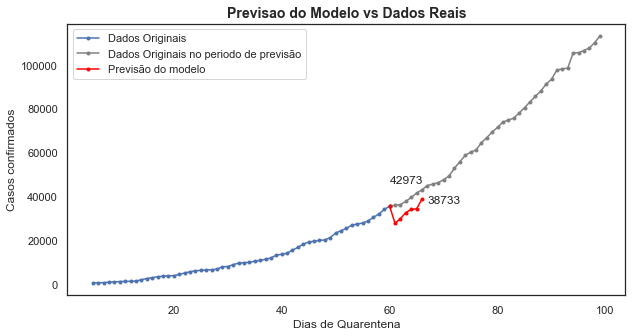

In [23]:
# No presuposto que tivessemos seguido com um isolamento mais rigido
Y_test60 = [[61,65,58,49,57,48,56,48], [62,65,59,48,58,49,57,48], [63,65,60,52,59,48,58,49],
            [64,65,61,65,60,52,59,48], [65,65,62,65,61,65,60,52], [66,65,63,65,62,65,61,65]]
X_prev60 = [60,61,62,63,64,65,66]
Y_prev60 = reg.predict(Y_test60)
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(df_casos_sp.dia_atual[:56], df_casos_sp.confirmed[:56], marker = '.')
plt.plot(df_casos_sp.dia_atual[55:], df_casos_sp.confirmed[55:], marker = '.', color='grey')
plt.plot(np.append(df_casos_sp.dia_atual[56:56],X_prev60, axis = 0), 
         np.append(df_casos_sp.confirmed[55:56], Y_prev60), marker = '.', color='red')
ax.annotate('{0:.0f}'.format(Y_prev60[-1:][0][0]), xy = (67,Y_prev60[-1:] - 2000))
ax.annotate(format(df_casos_sp.confirmed[61]), 
            xy = (60,df_casos_sp.confirmed[df_casos_sp.dia_atual == 66] + 3000))
ax.set_ylabel('Casos confirmados')
ax.set_xlabel('Dias de Quarentena')
ax.set_title('Previsao do Modelo vs Dados Reais', weight = 'bold', fontsize = 14)
ax.legend(('Dados Originais', 'Dados Originais no periodo de previsão','Previsão do modelo'));

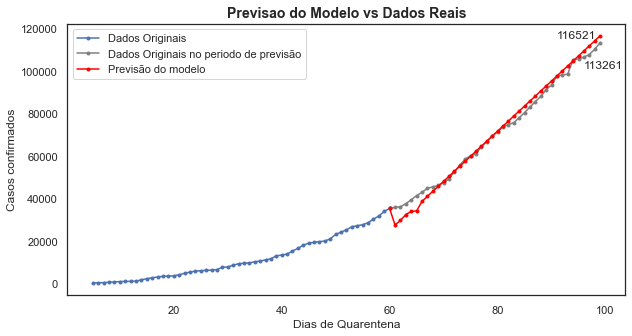

In [24]:
# No presuposto que tivessemos seguido com um isolamento mais rigido
Y_test60 = [[61,65,58,49,57,48,56,48], [62,65,59,48,58,49,57,48], [63,65,60,52,59,48,58,49],
            [64,65,61,65,60,52,59,48], [65,65,62,65,61,65,60,52], [66,65,63,65,62,65,61,65]]
b = df_casos_sp[['dia_atual', 'taxa_atual', 'dia-3', 'taxa-3', 'dia-4',
                 'taxa-4', 'dia-5', 'taxa-5']].loc[df_casos_sp.dia_atual >= 67]
b[['taxa_atual','taxa-3','taxa-4','taxa-5']] = 65
Y_test60 = Y_test60 + b.values.tolist()
X_prev60 = [x + 60 for x in range(40)]
Y_prev60 = reg.predict(Y_test60)
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(df_casos_sp.dia_atual[:56], df_casos_sp.confirmed[:56], marker = '.')
plt.plot(df_casos_sp.dia_atual[55:], df_casos_sp.confirmed[55:], marker = '.', color='grey')
plt.plot(np.append(df_casos_sp.dia_atual[56:56],X_prev60, axis = 0), 
         np.append(df_casos_sp.confirmed[55:56], Y_prev60), marker = '.', color='red')
ax.annotate('{0:.0f}'.format(Y_prev60[-1:][0][0]), xy = (91,Y_prev60[-1:] - 1000))
ax.annotate(format(df_casos_sp.confirmed[-1]), 
            xy = (96,df_casos_sp.confirmed[df_casos_sp.dia_atual == 99] - 12000))
ax.set_ylabel('Casos confirmados')
ax.set_xlabel('Dias de Quarentena')
ax.set_title('Previsao do Modelo vs Dados Reais', weight = 'bold', fontsize = 14)
ax.legend(('Dados Originais', 'Dados Originais no periodo de previsão','Previsão do modelo'));

Nos dois plots anteriores podemos ver a evolução da previsão do modelo adaptado a nossa hipótese, colocando uma porcentagem de isolamento de 65%. O primeiro mostra para um período de 6 dias a partir do dia 60 de quarentena a previsão do modelo, resultando em valores menores, mesmo que não muito distantes dos dados originais.

Porém quando extendemos o set de datos até o último dia que consta no nosso set de dados originas sob a mesma premissa do 65% de isolamento para o período todo, podemos ver como os casos aumentam igualando a curva original e no período final até ultrapassando ela.

Podem existir vários motivos pelos quais o modelo não se comporta da maneira esperada. Primeiramente pode ser por causa do modelo, falta de variáveis ou até falta de dados. Pode ser que talvez o modelo esteja tendendo a ser *overfitted*. Ou até talvez otimizar os hiperparâmetros do modelo, coisa que eu por enquanto não consegui fazer por falta de experiência.  

## **Em Conclusão**
  
Respondendo as perguntas realizadas no começo desse Notebook. Confirmamos que existe sim uma relação, inversamente proporcional aliás, entre as porcentagens de quarentena e os casos confirmados na cidade de São Paulo, porém temos que levar sempre em consideração que essa relação nem sempre indica causalidade.

Quarentena mais rígida implicaria menos casos? Analíticamente falando e com base no modelo é inconclusivo por conta dos motivos mencionados anteriormente. Porém o modelo, mesmo que imperfeito, por um breve momento reconheceu uma baixa nos casos. 

Então, se possível, por favor fique em casa!